# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


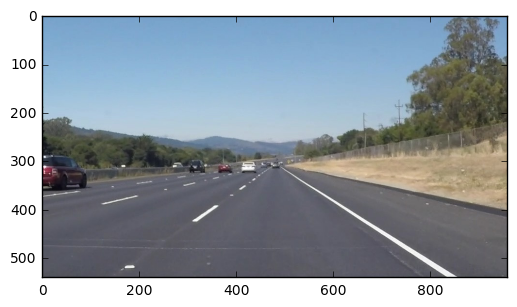

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [7]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

test_images/solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
[0, 1, 2, 3, 4, 5] [0, 1, 2, 3, 4, 5]
test_images/solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
[0, 1, 2, 3, 4, 5] [0, 1, 2, 3, 4, 5]
test_images/solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
[0, 1, 2, 3, 5, 6, 7] [0, 1, 2, 3, 5, 6]
test_images/solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
[0, 1, 2, 3, 4] [0, 1, 2, 3, 4, 5, 6, 7, 8]
test_images/solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
[0, 1, 2, 3, 4, 5, 6, 7] [0, 1, 2]
test_images/whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
[0, 1, 2, 3, 4, 5, 6, 8, 10] [1, 2, 3, 4, 5, 6, 7]


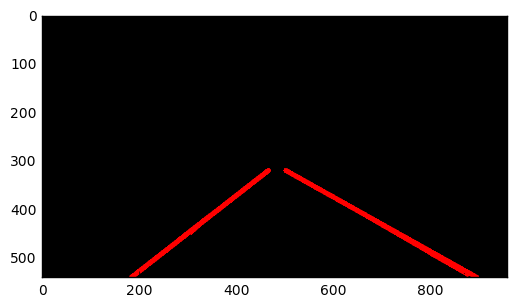

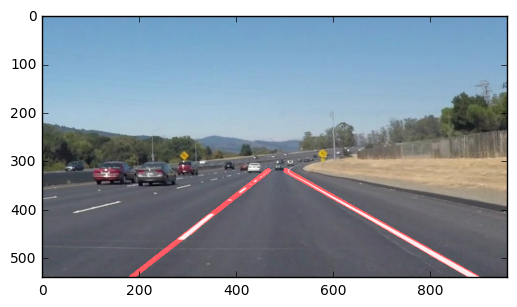

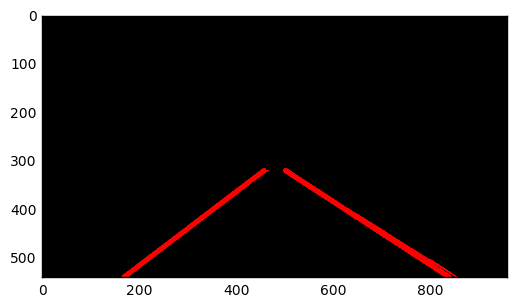

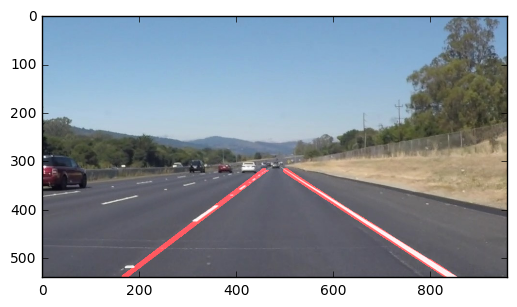

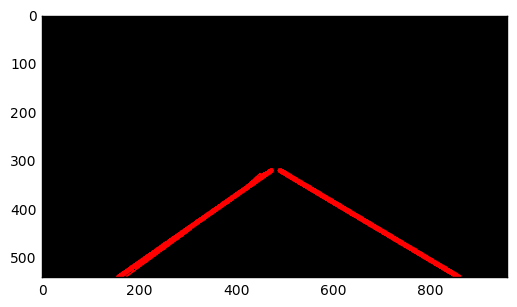

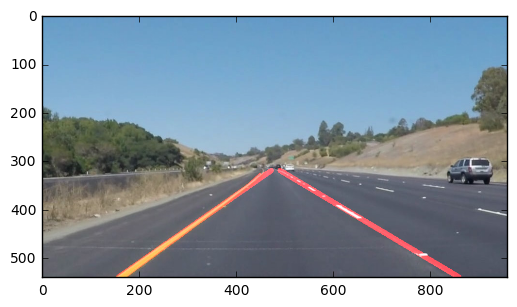

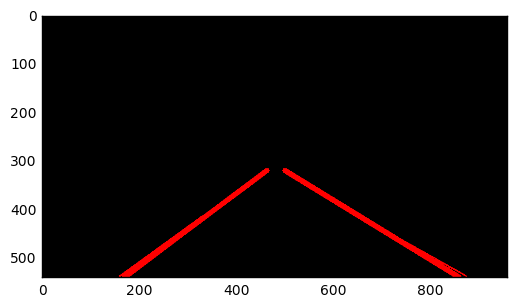

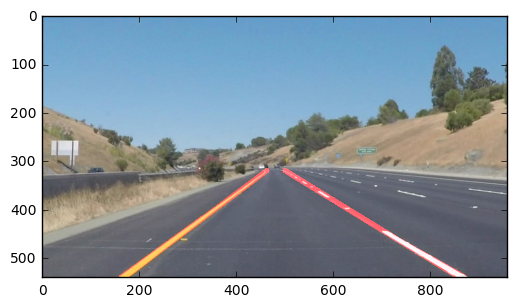

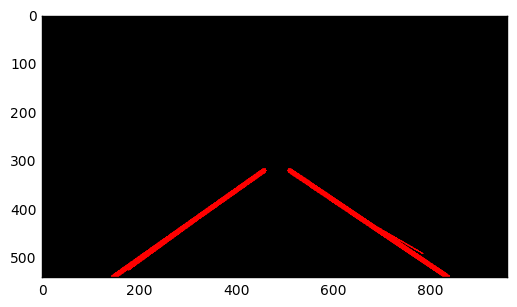

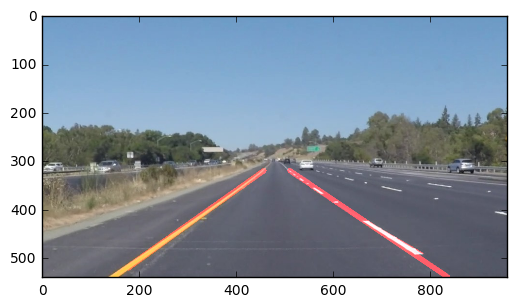

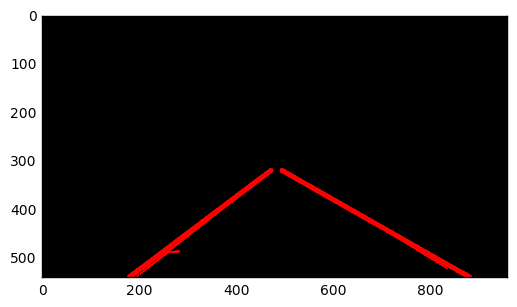

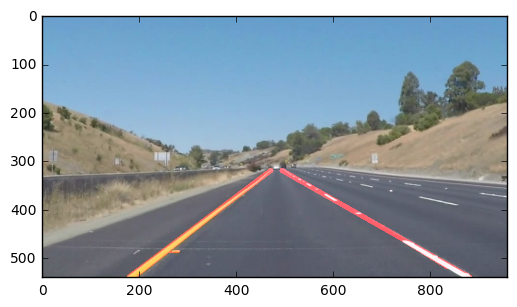

In [9]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import sys
import numpy as np
from sklearn import linear_model

def reject(data):
    idx = []
    for i in range(len(data)):
        if abs(data[i] - np.mean(data)) < 2 * np.std(data):
            idx.append(i)
    return idx
            
for img in os.listdir("test_images/"):
    print('test_images/' + img)
    #reading in an image
    image = mpimg.imread('test_images/' + img)
    gray = grayscale(image)
    blur_gray = cv2.GaussianBlur(gray,(5, 5),0)
    edges = cv2.Canny(blur_gray, 50, 150)
#     blur = gaussian_blur(gray, kernel_size = 5)
    #printing out some stats and plotting
    print('This image is:', type(edges), 'with dimesions:', edges.shape)
    
    imshape = edges.shape
    
    masked_edges = region_of_interest(edges, vertices = np.array([[(0,imshape[0]),(460, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32))
    
    line_image = hough_lines(masked_edges, rho = 2, theta = np.pi/180, threshold = 5, min_line_len = 40, max_line_gap = 20)
    
    lines = cv2.HoughLinesP(masked_edges, 2, np.pi/180, 5, np.array([]), 40, 20)
    
    color=[255, 0, 0]
    
    thickness=10
    
    # Create linear regression object
    regr1 = linear_model.LinearRegression()
    regr2 = linear_model.LinearRegression()
    
    L1_X = []
    L1_Y = []
    L2_X = []
    L2_Y = []
    L1_slope = []
    L2_slope = []
    L1_B = []
    L2_B = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            b = y2 - slope * x2
            if slope < 0:
                L1_X.append(x1)
                L1_X.append(x2)
                L1_Y.append(y1)
                L1_Y.append(y2)
                L1_slope.append(slope)
                L1_B.append(b)
            elif slope > 0:
                L2_X.append(x1)
                L2_X.append(x2)
                L2_Y.append(y1)
                L2_Y.append(y2)
                L2_slope.append(slope)
                L2_B.append(b)
            
    
    L1_N_X = []
    L1_N_Y = []
    L2_N_X = []
    L2_N_Y = []
    
    L1_idxs = list((set(reject(L1_slope)).union(set(reject(L1_B))))^(set(reject(L1_slope))^set(reject(L1_B))))
    for idx in L1_idxs:
        L1_N_X.append(L1_X[idx])
        L1_N_Y.append(L1_Y[idx])
        
    L2_idxs = list((set(reject(L2_slope)).union(set(reject(L2_B))))^(set(reject(L2_slope))^set(reject(L2_B))))
    print(L1_idxs, L2_idxs)
    for idx in L2_idxs:
        L2_N_X.append(L2_X[idx])
        L2_N_Y.append(L2_Y[idx])
    
    
#     print(L1_slope, L2_slope)
    if len(L1_N_Y) >0 and len(L1_N_X) > 0:
        # Train the model using the training sets
        
        regr1.fit(np.array(L1_N_Y)[:,None], np.array(L1_N_X)[:,None])
        cv2.line(line_image, (regr1.predict(320), 320), (regr1.predict(540), 540), color, thickness)
    
    if len(L2_N_Y) >0 and len(L2_N_X) > 0:
        regr2.fit(np.array(L2_N_Y)[:,None], np.array(L2_N_X)[:,None])
        cv2.line(line_image, (regr2.predict(320), 320), (regr2.predict(540), 540), color, thickness)
        
    plt.figure()
    plt.imshow(line_image)
    
    plt.figure()
    plt.imshow(weighted_img(image, line_image))


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [26]:
def reject(data):
    idx = []
    for i in range(len(data)):
        if abs(data[i] - np.mean(data)) < 2 * np.std(data):
            idx.append(i)
        else:
            print(data[i])
    return idx

L_slope_dot = []

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    #reading in an image
    gray = grayscale(image)
    blur_gray = cv2.GaussianBlur(gray,(5, 5),0)
    edges = cv2.Canny(blur_gray, 50, 150)
#     blur = gaussian_blur(gray, kernel_size = 5)
    #printing out some stats and plotting
    print('This image is:', type(edges), 'with dimesions:', edges.shape)
    
    imshape = edges.shape
    
    masked_edges = region_of_interest(edges, vertices = np.array([[(0,imshape[0]),(460, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32))
    
    line_image = hough_lines(masked_edges, rho = 2, theta = np.pi/180, threshold = 5, min_line_len = 40, max_line_gap = 20)
    
    lines = cv2.HoughLinesP(masked_edges, 2, np.pi/180, 5, np.array([]), 40, 20)
    
    color=[255, 0, 0]
    thickness=10
    
    # Create linear regression object
    regr1 = linear_model.LinearRegression()
    regr2 = linear_model.LinearRegression()
    
    L1_X = []
    L1_Y = []
    L2_X = []
    L2_Y = []
    L1_slope = []
    L2_slope = []
    L1_B = []
    L2_B = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            b = y2 - slope * x2
            if slope < 0:
                L1_X.append(x1)
                L1_X.append(x2)
                L1_Y.append(y1)
                L1_Y.append(y2)
                L1_slope.append(slope)
                L1_B.append(b)
            elif slope > 0:
                L2_X.append(x1)
                L2_X.append(x2)
                L2_Y.append(y1)
                L2_Y.append(y2)
                L2_slope.append(slope)
                L2_B.append(b)
            
    
    L1_N_X = []
    L1_N_Y = []
    L2_N_X = []
    L2_N_Y = []
    L1_N_slope = []
    L2_N_slope = []
    L1_N_B = []
    L2_N_B = []
    
    for idx in list((set(reject(L1_slope)).union(set(reject(L1_B))))^(set(reject(L1_slope))^set(reject(L1_B)))):
        L1_N_X.append(L1_X[idx])
        L1_N_Y.append(L1_Y[idx])
        L1_N_slope.append(L1_slope[idx])
        L1_N_B.append(L1_B[idx])
    for idx in list((set(reject(L2_slope)).union(set(reject(L2_B))))^(set(reject(L2_slope))^set(reject(L2_B)))):
        L2_N_X.append(L2_X[idx])
        L2_N_Y.append(L2_Y[idx])
        L2_N_slope.append(L2_slope[idx])
        L2_N_B.append(L2_B[idx])
                
    if len(L1_N_Y) > 0 and len(L1_N_X) > 0:
        # Train the model using the training sets
        regr1.fit(np.array(L1_N_Y)[:,None], np.array(L1_N_X)[:,None])
        cv2.line(line_image, (regr1.predict(320), 320), (regr1.predict(540), 540), color, thickness)
    
    if len(L2_N_Y) > 0 and len(L2_N_X) > 0:
#         slope = np.mean(L2_N_slope)
#         distance = np.mean(L2_N_B)
#         cv2.line(line_image, (int((320 - distance) / slope), 320), (int((540 - distance) / slope), 540), color, thickness)
        regr2.fit(np.array(L2_N_Y)[:,None], np.array(L2_N_X)[:,None])
        cv2.line(line_image, (regr2.predict(320), 320), (regr2.predict(540), 540), color, thickness)
    
    return weighted_img(image, line_image)

Let's try the one with the solid white lane on the right first ...

In [27]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.613636363636
601.659090909
-0.613636363636
601.659090909
0.708333333333
0.708333333333
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  2%|▏         | 5/222 [00:00<00:04, 49.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.613636363636
601.659090909
-0.613636363636
601.659090909
0.708333333333
0.708333333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
677.428571429
677.428571429
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-14.2045454545
-14.2045454545
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
36.4126984127
36.4126984127
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.565217391304
48.0869565217
0.565217391304
48.0869565217
This image is: <class 'numpy.ndarray'> w

  8%|▊         | 18/222 [00:00<00:03, 52.50it/s]

0.575
41.2
0.575
41.2
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.641025641026
618.076923077
-0.641025641026
618.076923077
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.625
608.125
-0.625
608.125
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.622222222222
-0.622222222222
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
690.086956522
690.086956522
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.8
680.8
-0.8
680.8
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 13%|█▎        | 29/222 [00:00<00:03, 50.73it/s]

-0.830769230769
698.184615385
-0.830769230769
698.184615385
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.833333333333
699.166666667
-0.833333333333
699.166666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
17.0975609756
17.0975609756
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.623762376238
0.623762376238
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 18%|█▊        | 40/222 [00:00<00:03, 51.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.7
-33.1
0.7
-33.1
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.522727272727
67.7045454545
0.522727272727
67.7045454545
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.830508474576
698.559322034
-0.830508474576
698.559322034
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.560975609756
40.1951219512
0.560975609756
40.1951219512
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.707317073171
0.707317073171
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 23%|██▎       | 50/222 [00:01<00:03, 44.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.641791044776
613.164179104
-0.641791044776
613.164179104
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 27%|██▋       | 61/222 [00:01<00:03, 45.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
16.5555555556
16.5555555556
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.685185185185
0.685185185185
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
25.2179487179
25.2179487179
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.624113475177
-20.3333333333
0.624113475177
-20.3333333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
24.9761904762
24.9761904762


 30%|██▉       | 66/222 [00:01<00:03, 46.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-27.8125
-27.8125
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.564516129032
41.6612903226
0.564516129032
41.6612903226
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
579.756097561
579.756097561
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-36.7073170732
-36.7073170732


 35%|███▌      | 78/222 [00:01<00:02, 49.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.603174603175
-0.603174603175
0.725
-54.775
0.725
-54.775
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
654.483870968
654.483870968
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
12.3333333333
12.3333333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 40%|████      | 89/222 [00:01<00:03, 43.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.6
594.8
-0.6
594.8
0.725
0.725
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 45%|████▍     | 99/222 [00:02<00:02, 43.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.712328767123
-37.5342465753
0.712328767123
-37.5342465753
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
672.0
672.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.578125
588.265625
-0.578125
588.265625
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.804347826087
680.456521739
-0.804347826087
680.456521739


 47%|████▋     | 104/222 [00:02<00:02, 40.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.576271186441
588.06779661
-0.576271186441
588.06779661
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-51.2857142857
-51.2857142857


 51%|█████▏    | 114/222 [00:02<00:02, 42.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.698630136986
-0.698630136986
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.549019607843
575.294117647
-0.549019607843
575.294117647
0.545454545455
52.3636363636
0.545454545455
52.3636363636
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.704347826087
646.060869565
-0.704347826087
646.060869565
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.5
559.5
-0.5
559.5
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 55%|█████▌    | 123/222 [00:02<00:02, 38.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.694805194805
0.694805194805
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.602941176471
0.602941176471


 60%|██████    | 134/222 [00:02<00:02, 43.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.6
599.6
-0.6
599.6
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
25.5744680851
25.5744680851
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.541666666667
52.5
0.541666666667
52.5
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.796296296296
687.092592593
-0.796296296296
687.092592593
0.54
53.76
0.54
53.76
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 65%|██████▌   | 145/222 [00:03<00:01, 47.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.610169491525
0.610169491525
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.520833333333
61.5
0.520833333333
61.5
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.690909090909
-34.9090909091
0.690909090909
-34.9090909091
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-18.0
-18.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 68%|██████▊   | 150/222 [00:03<00:01, 45.47it/s]

0.619047619048
3.7619047619
0.619047619048
3.7619047619
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.487804878049
79.2682926829
0.487804878049
79.2682926829
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 73%|███████▎  | 161/222 [00:03<00:01, 44.95it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.658536585366
-23.3902439024
0.658536585366
-23.3902439024
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.558139534884
-2.8064516129
0.558139534884
-2.8064516129
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 77%|███████▋  | 172/222 [00:03<00:01, 47.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.93023255814
748.976744186
-0.93023255814
748.976744186
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.894736842105
732.578947368
-0.894736842105
732.578947368
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.728260869565
664.652173913
-0.728260869565
664.652173913
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.487804878049
83.5365853659
0.487804878049
83.5365853659


 83%|████████▎ | 185/222 [00:03<00:00, 52.95it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.836363636364
705.036363636
-0.836363636364
705.036363636
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.714285714286
-0.714285714286
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.541666666667
84.2083333333
0.541666666667
84.2083333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.514705882353
63.6470588235
0.514705882353
63.6470588235
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 89%|████████▉ | 198/222 [00:04<00:00, 53.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.863636363636
714.5
-0.863636363636
714.5
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.676923076923
638.830769231
-0.676923076923
638.830769231
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.863636363636
-0.863636363636
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.540983606557
52.2295081967
0.540983606557
52.2295081967


 95%|█████████▍| 210/222 [00:04<00:00, 53.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.45652173913
98.3260869565
0.45652173913
98.3260869565
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.586206896552
0.586206896552
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.613636363636
-3.45454545455
0.613636363636
-3.45454545455
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


100%|█████████▉| 221/222 [00:04<00:00, 47.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.652777777778
628.152777778
-0.652777777778
628.152777778
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.470588235294
89.0588235294
0.470588235294
89.0588235294
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.891304347826
727.152173913
-0.891304347826
727.152173913
32.3414634146
32.3414634146


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.06 s, sys: 962 ms, total: 5.02 s
Wall time: 5.08 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [29]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 5/682 [00:00<00:14, 46.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.681818181818
625.590909091
-0.681818181818
625.590909091
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.111111111111
-0.125
477.111111111
480.125
-0.111111111111
-0.125
477.111111111
480.125
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.622009569378
609.531100478
-0.622009569378
609.531100478
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.781818181818
-88.6727272727
0.781818181818
-88.6727272727
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.707317073171
-43.756097561
0.707317073171
-43.756097561
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image i

  3%|▎         | 18/682 [00:00<00:12, 53.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-25.0697674419
-25.0697674419
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
667.869565217
667.869565217
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


  4%|▎         | 24/682 [00:00<00:12, 54.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


  4%|▍         | 29/682 [00:00<00:12, 52.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.814814814815
693.222222222
-0.814814814815
693.222222222
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.595238095238
601.404761905
-0.595238095238
601.404761905
0.575
33.75
0.575
33.75
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.921568627451
731.274509804
-0.921568627451
731.274509804
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.772727272727
-0.772727272727
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.659090909091
-0.659090909091
0.571428571429
29.8571428571
0.571428571429
29.8571428571
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


  5%|▌         | 36/682 [00:00<00:11, 55.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.446808510638
556.234042553
-0.446808510638
556.234042553
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


  6%|▌         | 42/682 [00:00<00:11, 56.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.833333333333
695.833333333
-0.833333333333
695.833333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.826086956522
690.608695652
-0.826086956522
690.608695652
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
619.977272727
619.977272727


  8%|▊         | 53/682 [00:00<00:13, 48.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.660377358491
633.41509434
-0.660377358491
633.41509434
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.19444444444
821.916666667
-1.19444444444
821.916666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.152173913043
522.108695652
-0.152173913043
522.108695652
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


  9%|▉         | 64/682 [00:01<00:12, 50.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.575
32.125
0.575
32.125
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.525
0.525
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.69696969697
-0.69696969697
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 11%|█         | 75/682 [00:01<00:12, 50.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.804347826087
686.152173913
-0.804347826087
686.152173913
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.659574468085
626.914893617
-0.659574468085
626.914893617
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-10.1
-10.1
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.875
711.125
-0.875
711.125
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.666666666667
-15.3333333333
0.666666666667
-15.3333333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 12%|█▏        | 81/682 [00:01<00:13, 44.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.581395348837
31.0697674419
0.581395348837
31.0697674419
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.925925925926
731.592592593
-0.925925925926
731.592592593


 13%|█▎        | 91/682 [00:01<00:13, 42.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.619047619048
603.904761905
-0.619047619048
603.904761905
0.545454545455
0.545454545455
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.77358490566
677.396226415
-0.77358490566
677.396226415


 14%|█▍        | 96/682 [00:01<00:13, 43.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.795454545455
685.909090909
-0.795454545455
685.909090909
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 15%|█▍        | 101/682 [00:02<00:13, 41.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 16%|█▌        | 106/682 [00:02<00:14, 39.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.688888888889
-28.0666666667
0.688888888889
-28.0666666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0416666666667
492.916666667
-0.0416666666667
492.916666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0425531914894
516.489361702
-0.0425531914894
516.489361702
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 16%|█▋        | 112/682 [00:02<00:13, 42.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.571428571429
592.428571429
-0.571428571429
592.428571429
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 17%|█▋        | 117/682 [00:02<00:13, 42.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.658536585366
-0.658536585366
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.85
708.05
-0.85
708.05
0.588235294118
0.588235294118
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 18%|█▊        | 123/682 [00:02<00:12, 45.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.741379310345
-0.741379310345
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 19%|█▉        | 128/682 [00:02<00:12, 45.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.933333333333
735.333333333
-0.933333333333
735.333333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.261904761905
521.238095238
-0.261904761905
521.238095238
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.217391304348
519.913043478
-0.217391304348
519.913043478
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
657.927152318
657.927152318
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 20%|██        | 138/682 [00:02<00:11, 45.78it/s]

0.581395348837
30.6046511628
0.581395348837
30.6046511628
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.63829787234
0.340425531915
0.63829787234
0.340425531915
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.743243243243
663.337837838
-0.743243243243
663.337837838
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 22%|██▏       | 149/682 [00:03<00:11, 47.39it/s]

-0.170212765957
516.829787234
-0.170212765957
516.829787234
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0222222222222
503.466666667
-0.0222222222222
503.466666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.775
678.075
-0.775
678.075
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.69512195122
-0.69512195122
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-56.0
-56.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 23%|██▎       | 160/682 [00:03<00:10, 49.23it/s]

-0.825
-0.825
0.511627906977
83.9069767442
0.511627906977
83.9069767442
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.795454545455
687.295454545
-0.795454545455
687.295454545
0.666666666667
-22.3333333333
0.666666666667
-22.3333333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.795454545455
695.454545455
-0.795454545455
695.454545455
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.481481481481
86.962962963
0.481481481481
86.962962963
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.97619047619
771.976190476
-0.97619047619
771.976190476
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> w

 25%|██▌       | 171/682 [00:03<00:10, 50.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.025
536.15
-0.025
536.15
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.571428571429
37.1428571429
0.571428571429
37.1428571429
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 26%|██▌       | 177/682 [00:03<00:10, 49.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.808510638298
698.382978723
-0.808510638298
698.382978723
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.860465116279
721.837209302
-0.860465116279
721.837209302
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.15
494.5
-0.15
494.5
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.063829787234
503.319148936
-0.063829787234
503.319148936
0.454545454545
98.4545454545
0.454545454545
98.4545454545
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 27%|██▋       | 183/682 [00:03<00:09, 50.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 28%|██▊       | 189/682 [00:03<00:09, 50.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.878048780488
727.243902439
-0.878048780488
727.243902439
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.630434782609
0.630434782609
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.634146341463
623.024390244
-0.634146341463
623.024390244
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.17073170732
816.585365854
-1.17073170732
816.585365854
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 29%|██▊       | 195/682 [00:04<00:09, 49.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.836363636364
-0.836363636364
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 29%|██▉       | 201/682 [00:04<00:09, 50.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.893617021277
730.489361702
-0.893617021277
730.489361702
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.826923076923
-0.826923076923
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.02325581395
787.581395349
-1.02325581395
787.581395349
0.505747126437
74.091954023
0.505747126437
74.091954023
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.478260869565
112.913043478
0.478260869565
112.913043478
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
690.696428571
690.696428571
0.175
238.8
0.175
238.8


 31%|███       | 213/682 [00:04<00:09, 50.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.91935483871
742.306451613
-0.91935483871
742.306451613
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.05263157895
790.736842105
-1.05263157895
790.736842105
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.977272727273
754.136363636
-0.977272727273
754.136363636
0.5
82.0
0.5
82.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.9
731.5
-0.9
731.5
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.720720720721
-0.720720720721
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 32%|███▏      | 219/682 [00:04<00:09, 49.96it/s]

0.62
1.5
0.62
1.5
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
107.658536585
107.658536585
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.634146341463
616.365853659
-0.634146341463
616.365853659
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.859375
711.578125
-0.859375
711.578125
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.672727272727
-0.672727272727
0.642857142857
-5.0
0.642857142857
-5.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.6796875
639.5390625
-0.6796875
639.5390625
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 33%|███▎      | 225/682 [00:04<00:08, 51.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.375
548.0
-0.375
548.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 34%|███▍      | 231/682 [00:04<00:08, 51.12it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
50.1588785047
50.1588785047
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
636.927272727
636.927272727
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 35%|███▍      | 237/682 [00:04<00:08, 52.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.666666666667
-0.666666666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 36%|███▌      | 243/682 [00:04<00:08, 50.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.698113207547
-43.8301886792
0.698113207547
-43.8301886792
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.694029850746
-0.694029850746
0.450980392157
100.37254902
0.450980392157
100.37254902
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.15
526.9
-0.15
526.9
0.448275862069
0.448275862069
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.7
-30.2
0.7
-30.2


 37%|███▋      | 255/682 [00:05<00:08, 50.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.413043478261
553.043478261
-0.413043478261
553.043478261
0.408163265306
124.040816327
0.408163265306
124.040816327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.418181818182
119.6
0.418181818182
119.6
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.42
152.88
0.42
152.88
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0487804878049
498.829268293
-0.0487804878049
498.829268293
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0576923076923
529.153846154
-0.0576923076923
529.153846154
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.565217391304
50.2173913043
0.565217391304
50.2173913043
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> w

 38%|███▊      | 261/682 [00:05<00:08, 49.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.796610169492
-0.796610169492
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.767441860465
675.837209302
-0.767441860465
675.837209302
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.926829268293
747.414634146
-0.926829268293
747.414634146
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.19512195122
500.829268293
-0.19512195122
500.829268293
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.505882352941
74.0588235294
0.505882352941
74.0588235294
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.46875
94.40625
0.46875
94.40625


 39%|███▉      | 267/682 [00:05<00:08, 50.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0408163265306
515.87755102
-0.0408163265306
515.87755102
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 40%|████      | 273/682 [00:05<00:08, 48.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.753086419753
-0.753086419753
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.671428571429
-19.6142857143
0.671428571429
-19.6142857143
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.652173913043
625.347826087
-0.652173913043
625.347826087
0.461538461538
97.3076923077
0.461538461538
97.3076923077
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 41%|████      | 278/682 [00:05<00:08, 48.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.97619047619
767.119047619
-0.97619047619
767.119047619
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.119047619048
415.976190476
-0.119047619048
415.976190476
0.448275862069
108.068965517
0.448275862069
108.068965517


 41%|████▏     | 283/682 [00:05<00:08, 47.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0232558139535
391.0
-0.0232558139535
391.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.780487804878
-0.780487804878
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.044776119403
388.895522388
0.044776119403
388.895522388
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.0161290322581
419.741935484
0.0161290322581
419.741935484


 42%|████▏     | 289/682 [00:05<00:08, 48.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.340909090909
532.386363636
-0.340909090909
532.386363636
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0227272727273
458.818181818
-0.0227272727273
458.818181818
0.0588235294118
436.0
0.0588235294118
436.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 43%|████▎     | 294/682 [00:06<00:08, 47.68it/s]

-0.08
-0.0444444444444
490.44
478.955555556
-0.08
-0.0444444444444
490.44
478.955555556
0.0208333333333
469.541666667
0.0208333333333
469.541666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0888888888889
511.511111111
-0.0888888888889
511.511111111
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.015873015873
-0.015873015873
0.0625
0.016393442623
523.6875
526.786885246
0.0625
0.016393442623
523.6875
526.786885246
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.666666666667
0.666666666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.02380952381
785.476190476
-1.02380952381
785.476190476
0.0434782608696
506.956521739
0.0434782608696
506.956521739
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.90625
735.15625
-0.90625
735.15625
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.659574468085
-0.659574468085
This image is: <class 'numpy.ndarray'> with dimesions:

 44%|████▍     | 299/682 [00:06<00:07, 48.07it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 45%|████▍     | 304/682 [00:06<00:08, 43.68it/s]

-1.05263157895
802.052631579
-1.05263157895
802.052631579
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.864864864865
714.783783784
-0.864864864865
714.783783784
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.093023255814
503.674418605
-0.093023255814
503.674418605
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 46%|████▌     | 314/682 [00:06<00:08, 43.04it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.3
521.3
-0.3
521.3
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 47%|████▋     | 319/682 [00:06<00:08, 42.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-10.0930232558
-10.0930232558
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.442307692308
0.442307692308
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.676258992806
-0.676258992806
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.753164556962
-0.753164556962
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 48%|████▊     | 325/682 [00:06<00:07, 44.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
15.835443038
15.835443038


 48%|████▊     | 330/682 [00:06<00:07, 44.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
62.2325581395
62.2325581395
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.854166666667
-0.854166666667
0.365853658537
146.024390244
0.365853658537
146.024390244
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.408163265306
123.265306122
0.408163265306
123.265306122
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.56
586.44
-0.56
586.44
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.754385964912
667.719298246
-0.754385964912
667.719298246
0.65
-3.1
0.65
-3.1


 49%|████▉     | 336/682 [00:06<00:07, 46.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.438596491228
110.280701754
0.438596491228
110.280701754


 50%|█████     | 341/682 [00:07<00:07, 45.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.380952380952
139.333333333
0.380952380952
139.333333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.725
-43.425
0.725
-43.425
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.416666666667
122.0
0.416666666667
122.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.139534883721
500.186046512
-0.139534883721
500.186046512
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.046511627907
517.325581395
-0.046511627907
517.325581395
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 52%|█████▏    | 352/682 [00:07<00:06, 47.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.415384615385
121.446153846
0.415384615385
121.446153846
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.414634146341
122.024390244
0.414634146341
122.024390244
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.666666666667
-0.666666666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.047619047619
545.619047619
-0.047619047619
545.619047619
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 53%|█████▎    | 363/682 [00:07<00:06, 48.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.421875
118.765625
0.421875
118.765625
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.45652173913
104.326086957
0.45652173913
104.326086957
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.783333333333
679.0
-0.783333333333
679.0
0.481481481481
89.1111111111
0.481481481481
89.1111111111
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.8
685.4
-0.8
685.4
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.05
789.8
-1.05
789.8
0.0238095238095
403.476190476
0.0238095238095
403.476190476


 55%|█████▍    | 374/682 [00:07<00:06, 49.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.0
769.0
-1.0
769.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0377358490566
474.490566038
-0.0377358490566
474.490566038
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.05
502.8
-0.05
502.8
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.14
-0.14
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.619047619048
607.80952381
-0.619047619048
607.80952381
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.707317073171
-31.1707317073
84.6585365854
0.707317073171
-31.1707317073
84.6585365854
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 56%|█████▋    | 385/682 [00:07<00:05, 49.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-13.8909090909
-13.8909090909
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.707317073171
-28.7317073171
0.707317073171
-28.7317073171
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.571428571429
589.571428571
-0.571428571429
589.571428571
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.483333333333
87.0333333333
0.483333333333
87.0333333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
618.836734694
618.836734694
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 58%|█████▊    | 396/682 [00:08<00:05, 50.61it/s]

0.5
81.0
0.5
81.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.565217391304
-0.565217391304
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.829268292683
-0.829268292683
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.637931034483
-0.637931034483
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.595238095238
596.69047619
-0.595238095238
596.69047619
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 59%|█████▉    | 402/682 [00:08<00:05, 49.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.537313432836
0.537313432836
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.590909090909
595.954545455
-0.590909090909
595.954545455
0.541666666667
58.4583333333
0.541666666667
58.4583333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 60%|█████▉    | 408/682 [00:08<00:05, 50.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 61%|██████    | 414/682 [00:08<00:05, 49.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.560975609756
58.4390243902
0.560975609756
58.4390243902
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 62%|██████▏   | 426/682 [00:08<00:05, 50.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.04761904762
768.619047619
-1.04761904762
768.619047619
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.672413793103
0.672413793103
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.8
921.4
-1.8
921.4
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0227272727273
537.227272727
-0.0227272727273
537.227272727
0.0192307692308
533.326923077
0.0192307692308
533.326923077
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 63%|██████▎   | 432/682 [00:08<00:05, 49.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.782608695652
680.434782609
-0.782608695652
680.434782609
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.634146341463
-0.634146341463
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.54347826087
61.0434782609
0.54347826087
61.0434782609
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.651162790698
-0.651162790698
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 64%|██████▍   | 437/682 [00:09<00:05, 45.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.442307692308
138.788461538
0.442307692308
138.788461538
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 65%|██████▍   | 442/682 [00:09<00:05, 42.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.72
-0.72
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.0
754.0
-1.0
754.0


 66%|██████▋   | 452/682 [00:09<00:05, 38.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.166666666667
508.333333333
-0.166666666667
508.333333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0851063829787
507.936170213
-0.0851063829787
507.936170213
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 67%|██████▋   | 460/682 [00:09<00:05, 37.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.95
738.4
-0.95
738.4
0.568965517241
38.6896551724
0.568965517241
38.6896551724
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.522727272727
567.863636364
-0.522727272727
567.863636364
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 69%|██████▉   | 470/682 [00:09<00:05, 39.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.829268292683
698.0
-0.829268292683
698.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.24242424242
783.424242424
-1.24242424242
783.424242424
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.666666666667
-13.0
0.666666666667
-13.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.738095238095
663.023809524
-0.738095238095
663.023809524


 70%|██████▉   | 475/682 [00:10<00:05, 41.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.738095238095
-0.738095238095
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.595744680851
599.021276596
-0.595744680851
599.021276596
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.653543307087
-4.44094488189
0.653543307087
-4.44094488189
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.62
0.62
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 70%|███████   | 480/682 [00:10<00:04, 43.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 71%|███████   | 485/682 [00:10<00:04, 41.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.56862745098
-0.56862745098
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.741379310345
-0.741379310345
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.738095238095
-0.738095238095
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.636363636364
-0.636363636364
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.642857142857
-0.642857142857
0.697674418605
0.697674418605
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0714285714286
509.214285714
-0.0714285714286
509.214285714
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 73%|███████▎  | 496/682 [00:10<00:04, 44.08it/s]

0.745454545455
-57.5454545455
0.745454545455
-57.5454545455
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.475
90.2
0.475
90.2
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.625
-0.625
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.191489361702
518.191489362
-0.191489361702
518.191489362


 74%|███████▍  | 507/682 [00:10<00:03, 46.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.740740740741
-0.740740740741
-53.7142857143
-53.7142857143
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.76
-0.76
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.648148148148
-0.648148148148
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.607843137255
602.647058824
-0.607843137255
602.647058824
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.541666666667
578.041666667
-0.541666666667
578.041666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.933333333333
726.733333333
-0.933333333333
726.733333333
This image is: <class 'numpy.ndarray'> with dimesions:

 76%|███████▌  | 517/682 [00:10<00:03, 45.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.25
529.0
-0.25
529.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.522727272727
582.363636364
-0.522727272727
582.363636364
-38.0
-38.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.561403508772
584.421052632
-0.561403508772
584.421052632
0.0217391304348
508.217391304
0.0217391304348
508.217391304
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.767441860465
675.558139535
-0.767441860465
675.558139535
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.739130434783
-0.739130434783
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.851851851852
-0.851851851852
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 77%|███████▋  | 522/682 [00:11<00:03, 42.22it/s]

-0.829787234043
700.872340426
-0.829787234043
700.872340426
0.574074074074
46.9444444444
0.574074074074
46.9444444444
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
40.025
40.025
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.714285714286
0.714285714286
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 77%|███████▋  | 527/682 [00:11<00:03, 40.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0444444444444
537.533333333
-0.0444444444444
537.533333333
0.0204081632653
531.081632653
0.0204081632653
531.081632653


 78%|███████▊  | 532/682 [00:11<00:03, 42.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.72
655.04
-0.72
655.04
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.8
693.4
-0.8
693.4
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.775510204082
684.591836735
-0.775510204082
684.591836735
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.945454545455
729.581818182
-0.945454545455
729.581818182


 79%|███████▊  | 537/682 [00:11<00:03, 44.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.673469387755
-19.6734693878
0.673469387755
-19.6734693878


 79%|███████▉  | 542/682 [00:11<00:03, 45.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0697674418605
504.069767442
-0.0697674418605
504.069767442
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.649253731343
-0.649253731343
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.632352941176
-0.632352941176
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.690476190476
0.690476190476
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.738095238095
-0.738095238095
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 80%|████████  | 547/682 [00:11<00:02, 46.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 81%|████████  | 552/682 [00:11<00:02, 46.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.63768115942
-10.9275362319
0.63768115942
-10.9275362319
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.642857142857
626.142857143
-0.642857142857
626.142857143
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.878048780488
721.463414634
-0.878048780488
721.463414634
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 82%|████████▏ | 557/682 [00:11<00:03, 39.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.857142857143
712.428571429
-0.857142857143
712.428571429
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.957446808511
749.638297872
-0.957446808511
749.638297872
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.07142857143
780.142857143
-1.07142857143
780.142857143
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.270833333333
529.5
-0.270833333333
529.5
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 83%|████████▎ | 566/682 [00:12<00:03, 35.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 84%|████████▍ | 575/682 [00:12<00:03, 35.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.704918032787
-0.704918032787
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.18
514.98
-0.18
514.98
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.133333333333
544.6
-0.133333333333
544.6
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.625
613.75
-0.625
613.75


 86%|████████▌ | 586/682 [00:12<00:02, 42.12it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.857142857143
-0.857142857143
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.571428571429
591.857142857
-0.571428571429
591.857142857
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.22
535.12
-0.22
535.12
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0681818181818
513.136363636
-0.0681818181818
513.136363636
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
685.452586207
685.452586207
0.0731707317073
520.195121951
0.0731707317073
520.195121951


 88%|████████▊ | 597/682 [00:12<00:01, 45.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.853658536585
719.512195122
-0.853658536585
719.512195122
0.551282051282
45.3461538462
0.551282051282
45.3461538462
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.688524590164
-0.688524590164
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.45
103.25
0.45
103.25
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.80487804878
702.707317073
-0.80487804878
702.707317073
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.928571428571
743.5
-0.928571428571
743.5


 89%|████████▉ | 607/682 [00:13<00:01, 46.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
45.6391752577
45.6391752577
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.80487804878
-0.80487804878
0.047619047619
508.380952381
0.047619047619
508.380952381
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.752212389381
-0.752212389381
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.533333333333
55.7333333333
0.533333333333
55.7333333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.568965517241
40.7068965517
0.568965517241
40.7068965517
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.025
782.975
-1.025
782.975
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 91%|█████████ | 618/682 [00:13<00:01, 48.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.177777777778
511.133333333
-0.177777777778
511.133333333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.0192307692308
534.5
0.0192307692308
534.5
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 92%|█████████▏| 629/682 [00:13<00:01, 49.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.88679245283
-0.88679245283
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.884615384615
729.730769231
-0.884615384615
729.730769231
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.047619047619
882.515151515
499.857142857
-0.047619047619
882.515151515
499.857142857
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.560975609756
40.756097561
0.560975609756
40.756097561
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.24242424242
874.121212121
-1.24242424

 94%|█████████▍| 640/682 [00:13<00:00, 50.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.404761904762
560.166666667
-0.404761904762
560.166666667
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.452380952381
102.523809524
0.452380952381
102.523809524
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.510638297872
88.2553191489
0.510638297872
88.2553191489
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.209302325581
539.488372093
-0.209302325581
539.488372093
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 95%|█████████▍| 646/682 [00:13<00:00, 49.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 96%|█████████▋| 658/682 [00:14<00:00, 44.77it/s]

-0.0444444444444
509.0
-0.0444444444444
509.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
0.0208333333333
527.25
0.0208333333333
527.25
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.804347826087
-0.804347826087
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.90243902439
726.731707317
-0.90243902439
726.731707317
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 97%|█████████▋| 663/682 [00:14<00:00, 41.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.795454545455
-0.795454545455
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.0652173913043
503.673913043
-0.0652173913043
503.673913043
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.777777777778
682.222222222
-0.777777777778
682.222222222
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.595238095238
600.071428571
-0.595238095238
600.071428571
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


 98%|█████████▊| 668/682 [00:14<00:00, 38.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
612.106382979
612.106382979
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.0
751.0
-1.0
751.0
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.1
484.6
-0.1
484.6
0.515625
66.84375
0.515625
66.84375


100%|█████████▉| 681/682 [00:14<00:00, 45.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.02
479.94
-0.02
479.94
0.508474576271
70.2881355932
0.508474576271
70.2881355932
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-0.655737704918
-0.655737704918
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)
-1.14285714286
826.428571429
-1.14285714286
826.428571429
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.8 s, sys: 2.82 s, total: 15.6 s
Wall time: 15.4 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [80]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4




  0%|          | 0/251 [00:00<?, ?it/s]

  1%|          | 3/251 [00:00<00:09, 24.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




  3%|▎         | 7/251 [00:00<00:09, 26.17it/s]

  4%|▍         | 10/251 [00:00<00:09, 25.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




  5%|▌         | 13/251 [00:00<00:09, 26.05it/s]

  6%|▋         | 16/251 [00:00<00:08, 26.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




  8%|▊         | 19/251 [00:00<00:08, 27.41it/s]

  9%|▉         | 23/251 [00:00<00:08, 28.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 10%|█         | 26/251 [00:00<00:07, 28.37it/s]

 12%|█▏        | 29/251 [00:01<00:07, 28.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 13%|█▎        | 32/251 [00:01<00:07, 29.13it/s]

 14%|█▍        | 35/251 [00:01<00:07, 29.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 16%|█▌        | 39/251 [00:01<00:07, 29.64it/s]

 17%|█▋        | 42/251 [00:01<00:07, 28.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 18%|█▊        | 45/251 [00:01<00:07, 26.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 19%|█▉        | 48/251 [00:01<00:08, 22.87it/s]

 20%|██        | 51/251 [00:01<00:08, 22.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 22%|██▏       | 54/251 [00:02<00:09, 21.47it/s]

 23%|██▎       | 57/251 [00:02<00:08, 21.72it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 24%|██▍       | 60/251 [00:02<00:09, 19.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 25%|██▌       | 63/251 [00:02<00:10, 17.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 26%|██▌       | 65/251 [00:02<00:11, 16.46it/s]

 27%|██▋       | 67/251 [00:02<00:11, 16.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 28%|██▊       | 70/251 [00:02<00:09, 18.37it/s]

 29%|██▉       | 73/251 [00:03<00:09, 19.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 30%|███       | 76/251 [00:03<00:08, 20.67it/s]

 31%|███▏      | 79/251 [00:03<00:08, 21.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 33%|███▎      | 82/251 [00:03<00:08, 20.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 34%|███▍      | 85/251 [00:03<00:08, 20.05it/s]

 35%|███▌      | 88/251 [00:03<00:07, 20.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 36%|███▋      | 91/251 [00:03<00:07, 20.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 37%|███▋      | 94/251 [00:04<00:07, 19.65it/s]

 38%|███▊      | 96/251 [00:04<00:07, 19.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 39%|███▉      | 98/251 [00:04<00:07, 19.37it/s]

 40%|███▉      | 100/251 [00:04<00:07, 19.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 41%|████      | 103/251 [00:04<00:07, 19.69it/s]

 42%|████▏     | 106/251 [00:04<00:06, 21.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 43%|████▎     | 109/251 [00:04<00:06, 20.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 45%|████▍     | 112/251 [00:05<00:06, 21.25it/s]

 46%|████▌     | 115/251 [00:05<00:05, 22.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 47%|████▋     | 118/251 [00:05<00:05, 22.34it/s]

 48%|████▊     | 121/251 [00:05<00:05, 23.07it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 49%|████▉     | 124/251 [00:05<00:05, 22.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 51%|█████     | 127/251 [00:05<00:05, 23.01it/s]

 52%|█████▏    | 130/251 [00:05<00:05, 22.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 53%|█████▎    | 133/251 [00:05<00:05, 22.41it/s]

 54%|█████▍    | 136/251 [00:06<00:05, 22.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 55%|█████▌    | 139/251 [00:06<00:05, 22.30it/s]

 57%|█████▋    | 142/251 [00:06<00:04, 23.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 58%|█████▊    | 145/251 [00:06<00:04, 23.03it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 59%|█████▉    | 148/251 [00:06<00:04, 21.77it/s]

 60%|██████    | 151/251 [00:06<00:04, 22.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 61%|██████▏   | 154/251 [00:06<00:04, 23.00it/s]

 63%|██████▎   | 157/251 [00:06<00:03, 23.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 64%|██████▎   | 160/251 [00:07<00:03, 23.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 65%|██████▍   | 163/251 [00:07<00:03, 22.70it/s]

 66%|██████▌   | 166/251 [00:07<00:03, 24.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 67%|██████▋   | 169/251 [00:07<00:03, 23.08it/s]

 69%|██████▊   | 172/251 [00:07<00:03, 23.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 70%|██████▉   | 175/251 [00:07<00:03, 22.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 71%|███████   | 178/251 [00:07<00:03, 22.67it/s]

 72%|███████▏  | 181/251 [00:08<00:03, 22.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 73%|███████▎  | 184/251 [00:08<00:02, 23.43it/s]

 75%|███████▍  | 187/251 [00:08<00:02, 23.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 76%|███████▌  | 190/251 [00:08<00:02, 23.32it/s]

 77%|███████▋  | 193/251 [00:08<00:02, 22.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 78%|███████▊  | 196/251 [00:08<00:02, 23.68it/s]

 79%|███████▉  | 199/251 [00:08<00:02, 23.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 80%|████████  | 202/251 [00:08<00:02, 23.10it/s]

 82%|████████▏ | 205/251 [00:09<00:01, 24.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 83%|████████▎ | 208/251 [00:09<00:01, 24.50it/s]

 84%|████████▍ | 211/251 [00:09<00:01, 24.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 85%|████████▌ | 214/251 [00:09<00:01, 23.81it/s]

 86%|████████▋ | 217/251 [00:09<00:01, 24.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 88%|████████▊ | 220/251 [00:09<00:01, 24.53it/s]

 89%|████████▉ | 223/251 [00:09<00:01, 25.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 90%|█████████ | 226/251 [00:09<00:00, 26.06it/s]

 91%|█████████ | 229/251 [00:09<00:00, 25.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 92%|█████████▏| 232/251 [00:10<00:00, 24.81it/s]

 94%|█████████▎| 235/251 [00:10<00:00, 25.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 95%|█████████▍| 238/251 [00:10<00:00, 25.50it/s]

 96%|█████████▌| 241/251 [00:10<00:00, 25.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




 97%|█████████▋| 244/251 [00:10<00:00, 25.15it/s]

 98%|█████████▊| 247/251 [00:10<00:00, 26.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)




100%|█████████▉| 250/251 [00:10<00:00, 26.12it/s]

100%|██████████| 251/251 [00:10<00:00, 23.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 9.3 s, sys: 1.68 s, total: 11 s
Wall time: 11.8 s


In [81]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))